In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [4]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

# Imports
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [5]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [18]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/CNN/cnn_model.weights.h5'
# checkpoint_filepath = './model_tensorflow2/weights'

In [7]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203791, 10, 40, 1) (203791, 3)


In [8]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 159822)
(159813, 10, 40, 1) (159813, 3)


In [9]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50941, 10, 40, 1) (50941, 3)


In [10]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203791, 10, 40, 1) (203791, 3)
(50941, 10, 40, 1) (50941, 3)
(159813, 10, 40, 1) (159813, 3)


In [15]:
def create_cnn1(T, NF):
    input_lmd = Input(shape=(T, NF, 1))  # Input shape is the same as the original

    # Convolutional Block
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_lmd)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Add more convolutional layers
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Flatten the output and add Dense layers
    flatten = Flatten()(pool2)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)

    # Output layer for classification
    out = Dense(3, activation='softmax')(dropout)

    # Compile the model
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [16]:
cnn1 = create_cnn1(trainX_CNN.shape[1], trainX_CNN.shape[2])
cnn1.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10, 40, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 40, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 20, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 5, 20, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 20, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 10, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,347 (895.89 KB)

 Trainable params: 229,347 (895.89 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training the CNN1 model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

cnn1.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
         epochs=10, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])


Epoch 1/10
1593/1593 - 20s - 12ms/step - accuracy: 0.4284 - loss: 1.0068 - val_accuracy: 0.3727 - val_loss: 1.0761
Epoch 2/10
1593/1593 - 12s - 8ms/step - accuracy: 0.4905 - loss: 0.9139 - val_accuracy: 0.3572 - val_loss: 1.0685
Epoch 3/10
1593/1593 - 10s - 6ms/step - accuracy: 0.5204 - loss: 0.8900 - val_accuracy: 0.4762 - val_loss: 0.9882
Epoch 4/10
1593/1593 - 8s - 5ms/step - accuracy: 0.5544 - loss: 0.8687 - val_accuracy: 0.3818 - val_loss: 1.0528
Epoch 5/10
1593/1593 - 9s - 6ms/step - accuracy: 0.5977 - loss: 0.8342 - val_accuracy: 0.4709 - val_loss: 0.9829
Epoch 6/10
1593/1593 - 10s - 6ms/step - accuracy: 0.6386 - loss: 0.7891 - val_accuracy: 0.3814 - val_loss: 1.2265
Epoch 7/10
1593/1593 - 10s - 6ms/step - accuracy: 0.6683 - loss: 0.7524 - val_accuracy: 0.5429 - val_loss: 0.9186
Epoch 8/10
1593/1593 - 8s - 5ms/step - accuracy: 0.6863 - loss: 0.7255 - val_accuracy: 0.4708 - val_loss: 0.9990
Epoch 9/10
1593/1593 - 8s - 5ms/step - accuracy: 0.6980 - loss: 0.7081 - val_accuracy: 0.5

In [20]:
# Load weights and predict
cnn1.load_weights(checkpoint_filepath)
pred = cnn1.predict(testX_CNN)

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [21]:
# Evaluate the performance
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))



accuracy_score: 0.6935605989500229
              precision    recall  f1-score   support

           0     0.6197    0.7570    0.6815     53063
           1     0.7301    0.7659    0.7475     57151
           2     0.7678    0.5424    0.6357     49599

    accuracy                         0.6936    159813
   macro avg     0.7058    0.6884    0.6882    159813
weighted avg     0.7051    0.6936    0.6909    159813



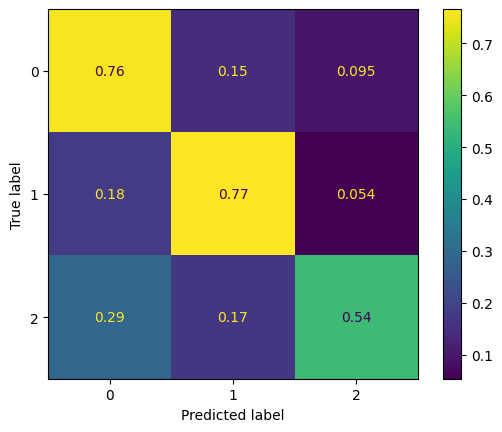

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()